In [1]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === Load Data ===
train = pd.read_csv("/kaggle/input/preprocessing-2/train_processed.csv")
test  = pd.read_csv("/kaggle/input/preprocessing-2/test_processed.csv")

In [2]:
TARGET = "HotelValue"
features = [c for c in train.columns if c not in ["Id", TARGET]]

X = train[features]
y = train[TARGET]

# === Split Train/Validation ===
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# === Separate Categorical Columns ===
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# === Encode Categoricals ===
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols].astype(str))
X_valid[cat_cols] = encoder.transform(X_valid[cat_cols].astype(str))
test[cat_cols]    = encoder.transform(test[cat_cols].astype(str))

# === Handle Missing Values ===
num_imputer = SimpleImputer(strategy="median")

# Apply only to feature columns (exclude Id if it’s in test)
X_train = pd.DataFrame(num_imputer.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(num_imputer.transform(X_valid), columns=X_valid.columns)

# Ensure we only impute the same feature columns in test
test_features = [c for c in test.columns if c != "Id"]
test[test_features] = num_imputer.transform(test[test_features])

# === Log-transform Target ===
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

In [4]:
# === Grid Search for Decision Tree ===
param_grid = {
    'max_depth': [5, 8, 10, 12, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train_log)

print(" Best Parameters:", grid.best_params_)
print(f"Best CV RMSE (log scale): {-grid.best_score_:.2f}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
 Best Parameters: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV RMSE (log scale): 0.19


In [5]:
# === Train Final Model ===
best_model = DecisionTreeRegressor(**grid.best_params_, random_state=42)
best_model.fit(X_train, y_train_log)

# === Evaluate on Validation Set ===
y_valid_pred_log = best_model.predict(X_valid)
y_valid_pred = np.expm1(y_valid_pred_log)

val_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
val_r2 = r2_score(y_valid, y_valid_pred)

print(f"Validation RMSE (final, original scale): {val_rmse:,.2f}")
print(f"Validation R² (final): {val_r2:.4f}")

Validation RMSE (final, original scale): 38,823.51
Validation R² (final): 0.7848


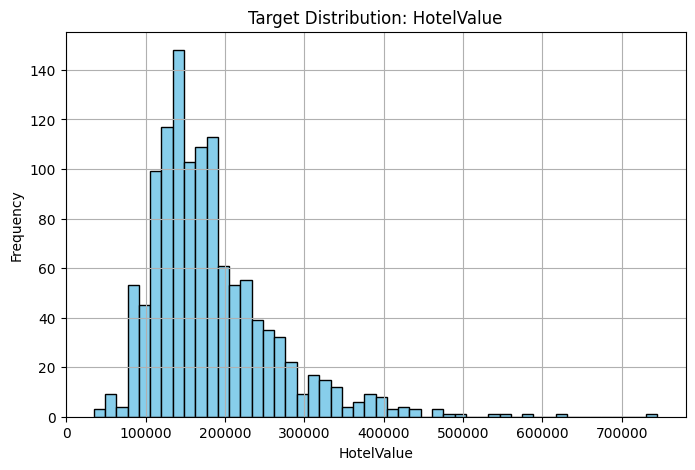

In [6]:
# === Plots ===

## Target Distribution
plt.figure(figsize=(8,5))
plt.hist(y, bins=50, color="skyblue", edgecolor="k")
plt.title("Target Distribution: HotelValue")
plt.xlabel("HotelValue")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

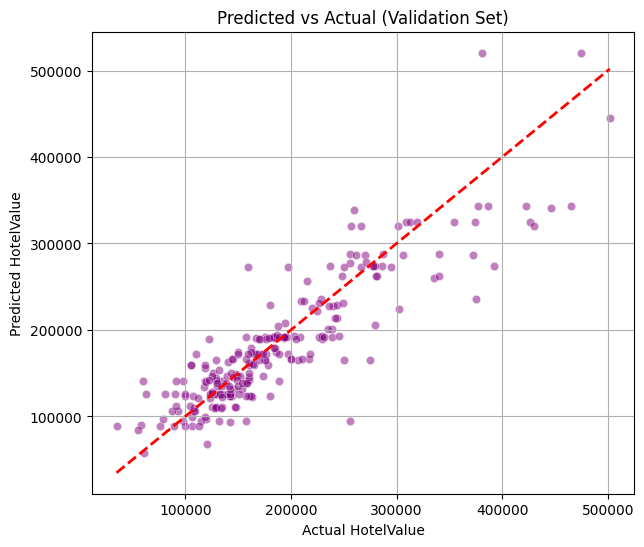

In [7]:
## Predicted vs Actual
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_valid, y=y_valid_pred, alpha=0.5, color='purple')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2)
plt.xlabel("Actual HotelValue")
plt.ylabel("Predicted HotelValue")
plt.title("Predicted vs Actual (Validation Set)")
plt.grid(True)
plt.show()

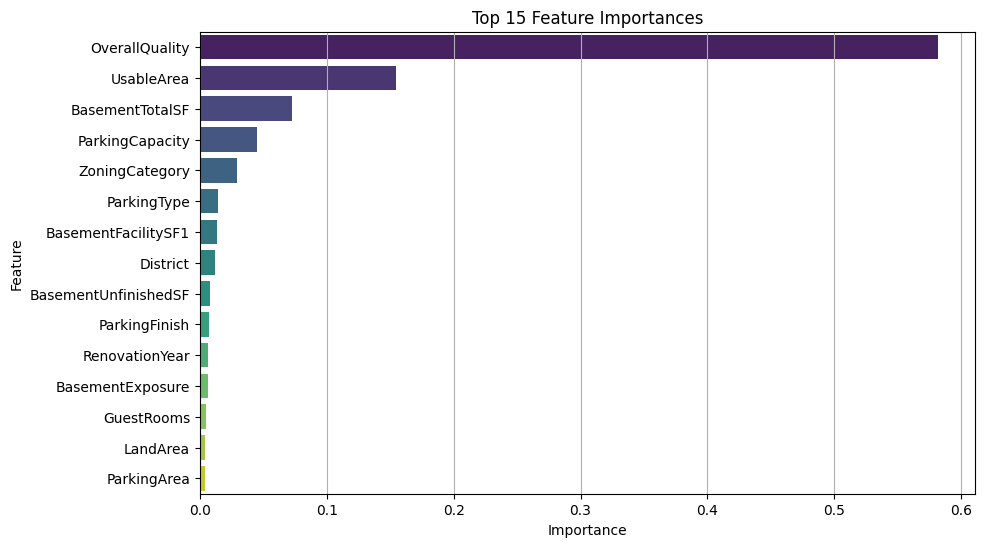

In [8]:
##  Feature Importances
importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances[:15], y=importances.index[:15], palette="viridis")
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.show()

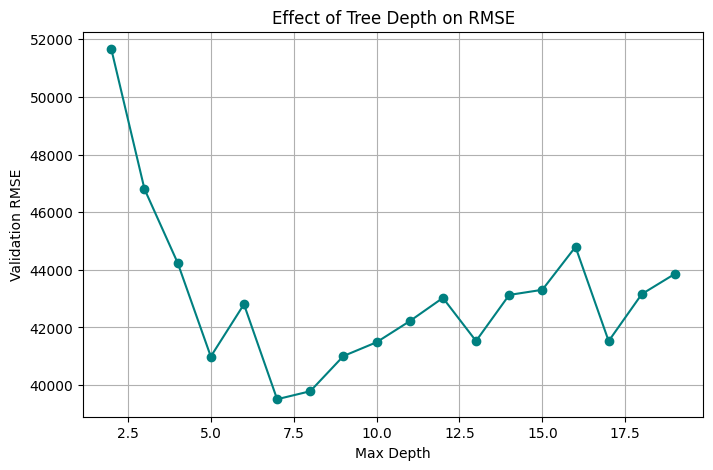

In [9]:
##  Depth vs RMSE Visualization
depths = range(2, 20)
rmse_scores = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    preds = model.fit(X_train, y_train_log).predict(X_valid)
    rmse = mean_squared_error(y_valid, np.expm1(preds), squared=False)
    rmse_scores.append(rmse)

plt.figure(figsize=(8,5))
plt.plot(depths, rmse_scores, marker='o', color='teal')
plt.xlabel("Max Depth")
plt.ylabel("Validation RMSE")
plt.title("Effect of Tree Depth on RMSE")
plt.grid(True)
plt.show()

In [10]:
# === Predict on Test Set ===
# Drop Id if it exists in test
test_features = [c for c in test.columns if c != "Id"]
y_test_pred = np.expm1(best_model.predict(test[test_features]))


submission = pd.DataFrame({
    "Id": test["Id"],
    "HotelValue": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("submission.csv created successfully!")

submission.csv created successfully!
